# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),        
        pystrata.output.MaxAccelProfile()
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

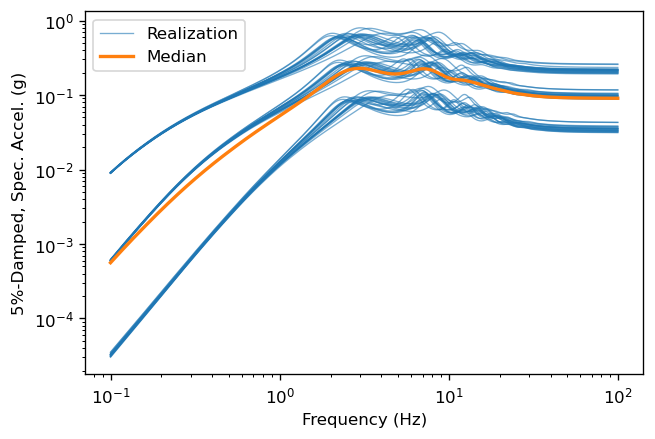

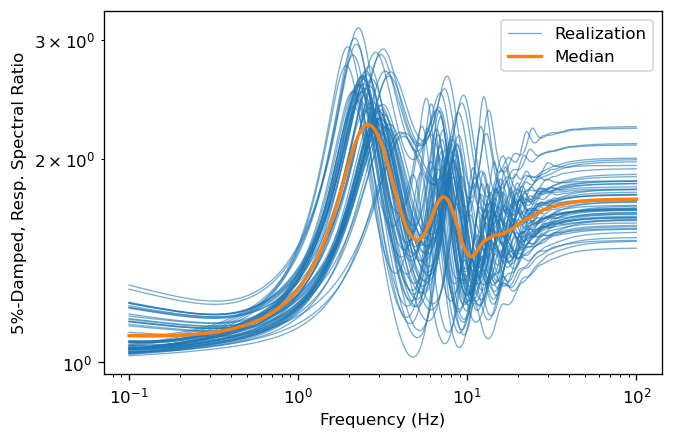

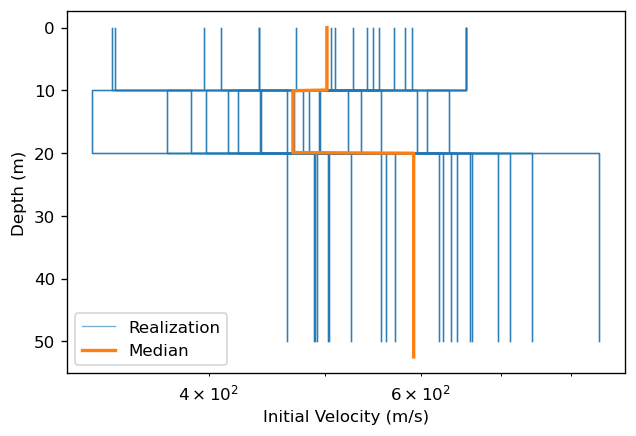

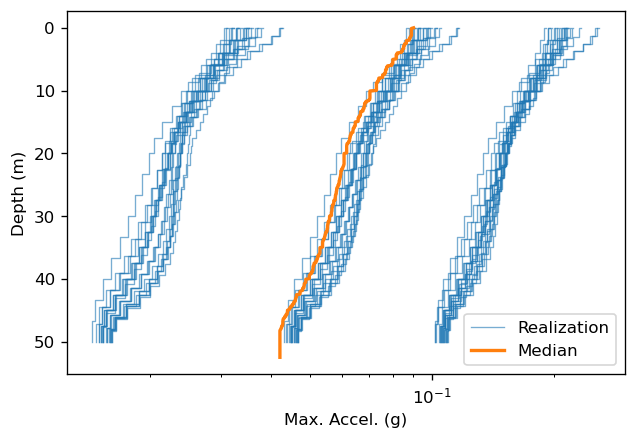

In [9]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [10]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.221093  1.073960  1.046285  1.160393  1.054396  1.033606   
0.101394    1.220302  1.073900  1.046641  1.159884  1.054365  1.033872   
0.102807    1.219514  1.073844  1.047000  1.159376  1.054339  1.034141   
0.104240    1.218729  1.073794  1.047363  1.158871  1.054317  1.034413   
0.105693    1.217947  1.073750  1.047730  1.158368  1.054300  1.034688   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.931720  1.850948  1.724594  1.800002  1.734478  1.656268   
95.932095   1.931800  1.851025  1.724690  1.800064  1.734530  1.656335   
97.269336   1.931877  1.851100  1.724784  1.800124  1.734581  1.656399   
98.625218   1.931952  1.851173  1.724875  1.800181  1.734631  1.656462   
100.000000  1.932025  1.851244  1.724963  1.800238  1.734679  1.656523   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.205555  1.068130  1.041848  1.157121  ...  1.028357  1.150518   
0.101394    1.204781  1.068075  1.042173  1.156634  ...  1.028584  1.150040   
0.102807    1.204009  1.068024  1.042502  1.156149  ...  1.028814  1.149563   
0.104240    1.203240  1.067979  1.042834  1.155665  ...  1.029046  1.149088   
0.105693    1.202475  1.067939  1.043170  1.155184  ...  1.029281  1.148615   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.634806  1.592696  1.473997  1.837028  ...  1.513425  1.741632   
95.932095   1.634870  1.592762  1.474077  1.837086  ...  1.513481  1.741682   
97.269336   1.634931  1.592827  1.474155  1.837143  ...  1.513535  1.741730   
98.625218   1.634990  1.592889  1.474230  1.837198  ...  1.513588  1.741777   
100.000000  1.635048  1.592949  1.474303  1.837251  ...  1.513639  1.741822   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.050879  1.031179  1.147453  1.050064  1.030826  1.131558   
0.101394    1.050853  1.031427  1.147001  1.050040  1.031072  1.131179   
0.102807    1.050830  1.031678  1.146550  1.050019  1.031321  1.130802   
0.104240    1.050812  1.031932  1.146101  1.050002  1.031572  1.130426   
0.105693    1.050798  1.032188  1.145654  1.049990  1.031826  1.130052   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.680808  1.606128  1.767937  1.704897  1.637053  1.816550   
95.932095   1.680850  1.606181  1.767995  1.704945  1.637114  1.816589   
97.269336   1.680890  1.606233  1.768052  1.704992  1.637173  1.816628   
98.625218   1.680929  1.606284  1.768107  1.705038  1.637230  1.816665   
100.000000  1.680967  1.606332  1.768161  1.705082  1.637286  1.816700   

                                
                  m1        m2  
0.100000    1.044693  1.027353  
0.101394    1.044675  1.027573  
0.102807    1.044661  1.027796  
0.104240    1.044652  1.028021  
0.105693    1.044646  1.028249  
...              ...       ...  
94.613238   1.741422  1.680734  
95.932095   1.741450  1.680774  
97.269336   1.741478  1.680813  
98.625218   1.741504  1.680850  
100.000000  1.741530  1.680887  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [11]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.reset_index().melt(id_vars="freq")
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.221093
1,0.101394,p0,m0,1.220302
2,0.102807,p0,m0,1.219514
3,0.104240,p0,m0,1.218729
4,0.105693,p0,m0,1.217947
...,...,...,...,...
29995,94.613238,p19,m2,1.680734
29996,95.932095,p19,m2,1.680774
29997,97.269336,p19,m2,1.680813
29998,98.625218,p19,m2,1.680850


In [12]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.188552  0.040416
           m1      1.063313  0.014273
           m2      1.039304  0.009279
0.101394   m0      1.187905  0.040242
           m1      1.063267  0.014251
...                     ...       ...
98.625218  m1      1.755348  0.077488
           m2      1.652957  0.078979
100.000000 m0      1.823843  0.086956
           m1      1.755406  0.077485
           m2      1.653029  0.078974

[1500 rows x 2 columns]

In [13]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.040416  1.188552  0.014273  1.063313  0.009279  1.039304
0.101394    0.040242  1.187905  0.014251  1.063267  0.009342  1.039610
0.102807    0.040069  1.187259  0.014229  1.063226  0.009405  1.039919
0.104240    0.039895  1.186616  0.014209  1.063190  0.009469  1.040231
0.105693    0.039723  1.185975  0.014189  1.063159  0.009533  1.040546
...              ...       ...       ...       ...       ...       ...
94.613238   0.086971  1.823579  0.077497  1.755161  0.078995  1.652724
95.932095   0.086967  1.823648  0.077494  1.755225  0.078989  1.652804
97.269336   0.086963  1.823715  0.077491  1.755287  0.078984  1.652882
98.625218   0.086959  1.823780  0.077488  1.755348  0.078979  1.652957
100.000000  0.086956  1.823843  0.077485  1.755406  0.078974  1.653029

[500 rows x 6 columns]

Access the properties of each motion like:

In [14]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.040416,1.188552
0.101394,0.040242,1.187905
0.102807,0.040069,1.187259
0.104240,0.039895,1.186616
0.105693,0.039723,1.185975
...,...,...
94.613238,0.086971,1.823579
95.932095,0.086967,1.823648
97.269336,0.086963,1.823715


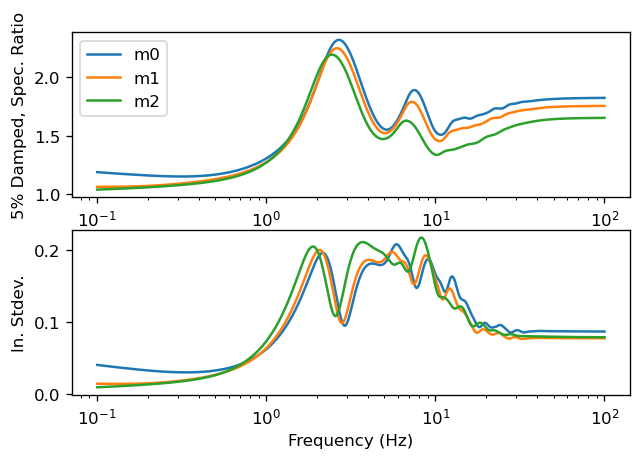

In [15]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.index, g[(name, key)], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;